In [178]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [179]:
df = pd.read_csv('Kaggle_TED_video_metadata_balanced.csv')

In [180]:
df['views'] = pd.to_numeric(df['views'], errors='coerce').fillna(0).astype(int)
df['likes'] = pd.to_numeric(df['likes'], errors='coerce').fillna(0).astype(int)
df['dislikes'] = pd.to_numeric(df['dislikes'], errors='coerce').fillna(0).astype(int)
df['comment_count'] = pd.to_numeric(df['comment_count'], errors='coerce').fillna(0).astype(int)
df['category_id'] = pd.to_numeric(df['category_id'], errors='coerce').fillna(0).astype(int)

df['title_length'] = df['title'].apply(len)
df['duration_seconds'] = pd.to_timedelta(df['duration'], errors='coerce').dt.total_seconds().fillna(0).astype(int)

df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')

df['published_at'] = df['published_at'].fillna(df['published_at'].min())

In [181]:
# Create time-based features
df['year'] = df['published_at'].dt.year
df['month'] = df['published_at'].dt.month
df['day'] = df['published_at'].dt.day
df['hour'] = df['published_at'].dt.hour

In [182]:
df['days_since_first'] = (df['published_at'] - df['published_at'].min()).dt.days

In [183]:
df['tags_count'] = df['tags'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

In [184]:
df['log_views'] = np.log1p(df['views'])
df['log_likes'] = np.log1p(df['likes'])
df['log_comments'] = np.log1p(df['comment_count'])

In [185]:
model_features = ["log_views", "log_likes", "log_comments"]

In [186]:
# Load pre-trained scaler and clustering model
scaler = joblib.load('scaler_ted_model_balanced.pkl')
kmeans = joblib.load('kmeans_ted_model_balanced.pkl')

In [187]:
# Scale the data
df_model = df[model_features]
df_scaled = scaler.transform(df_model)

In [188]:
# Predict the clusters
df['predicted_cluster'] = kmeans.predict(df_scaled)

In [189]:
print("Initial Data with Clusters:")
print(df[['title', 'views', 'likes', 'comment_count', 'predicted_cluster']].head())

Initial Data with Clusters:
                                               title   views  likes  \
0  Stories from a home for terminally ill childre...   77455   1768   
1    Why our screens make us less happy | Adam Alter  800326  20579   
2                A tribute to nurses | Carolyn Jones   87635   1877   
3  Asking for help is a strength, not a weakness ...  190840   4726   
4  Don't feel sorry for refugees -- believe in th...   98523   2669   

   comment_count  predicted_cluster  
0             49                  1  
1            572                  0  
2             48                  1  
3            187                  1  
4            226                  1  


In [190]:
# Set 'published_at' as the index for time-based analysis
df.set_index('published_at', inplace=True)

# Resample data to weekly frequency, summing views and likes for each week
df_weekly = df.resample('W').sum()

df_weekly['views_change'] = df_weekly['views'].diff()
df_weekly['likes_change'] = df_weekly['likes'].diff()

# Rolling averages for better visualization of trends
df_weekly['views_rolling_avg'] = df_weekly['views'].rolling(window=4).mean()
df_weekly['likes_rolling_avg'] = df_weekly['likes'].rolling(window=4).mean()

print("Weekly Aggregated Data with Rolling Averages:")
print(df_weekly.head())

Weekly Aggregated Data with Rolling Averages:
                                                                       title  \
published_at                                                                   
2007-01-07 00:00:00+00:00  Do schools kill creativity? | Sir Ken Robinson...   
2007-01-14 00:00:00+00:00  Bjorn Lomborg: Global priorities bigger than c...   
2007-01-21 00:00:00+00:00  Nerdcore comedy | Ze FrankMena Trott: How blog...   
2007-01-28 00:00:00+00:00                                                  0   
2007-02-04 00:00:00+00:00                                                  0   

                                                                        tags  \
published_at                                                                   
2007-01-07 00:00:00+00:00  Ken,Robinson,TED,TEDTalks,Talks,TED2006,educat...   
2007-01-14 00:00:00+00:00  TED,TEDTalks,talks,Bjorn Lomborg,priorities,sa...   
2007-01-21 00:00:00+00:00  Ze Frank,TED,TEDTalks,Talk,nerdcore,standupMen

In [191]:
last_month = df_weekly.tail(4)

print("Weekly Change Over the Last Month:")
print(last_month[['views_change', 'likes_change']])

Weekly Change Over the Last Month:
                           views_change  likes_change
published_at                                         
2024-03-24 00:00:00+00:00           0.0           0.0
2024-03-31 00:00:00+00:00           0.0           0.0
2024-04-07 00:00:00+00:00           0.0           0.0
2024-04-14 00:00:00+00:00     9085209.0      652475.0


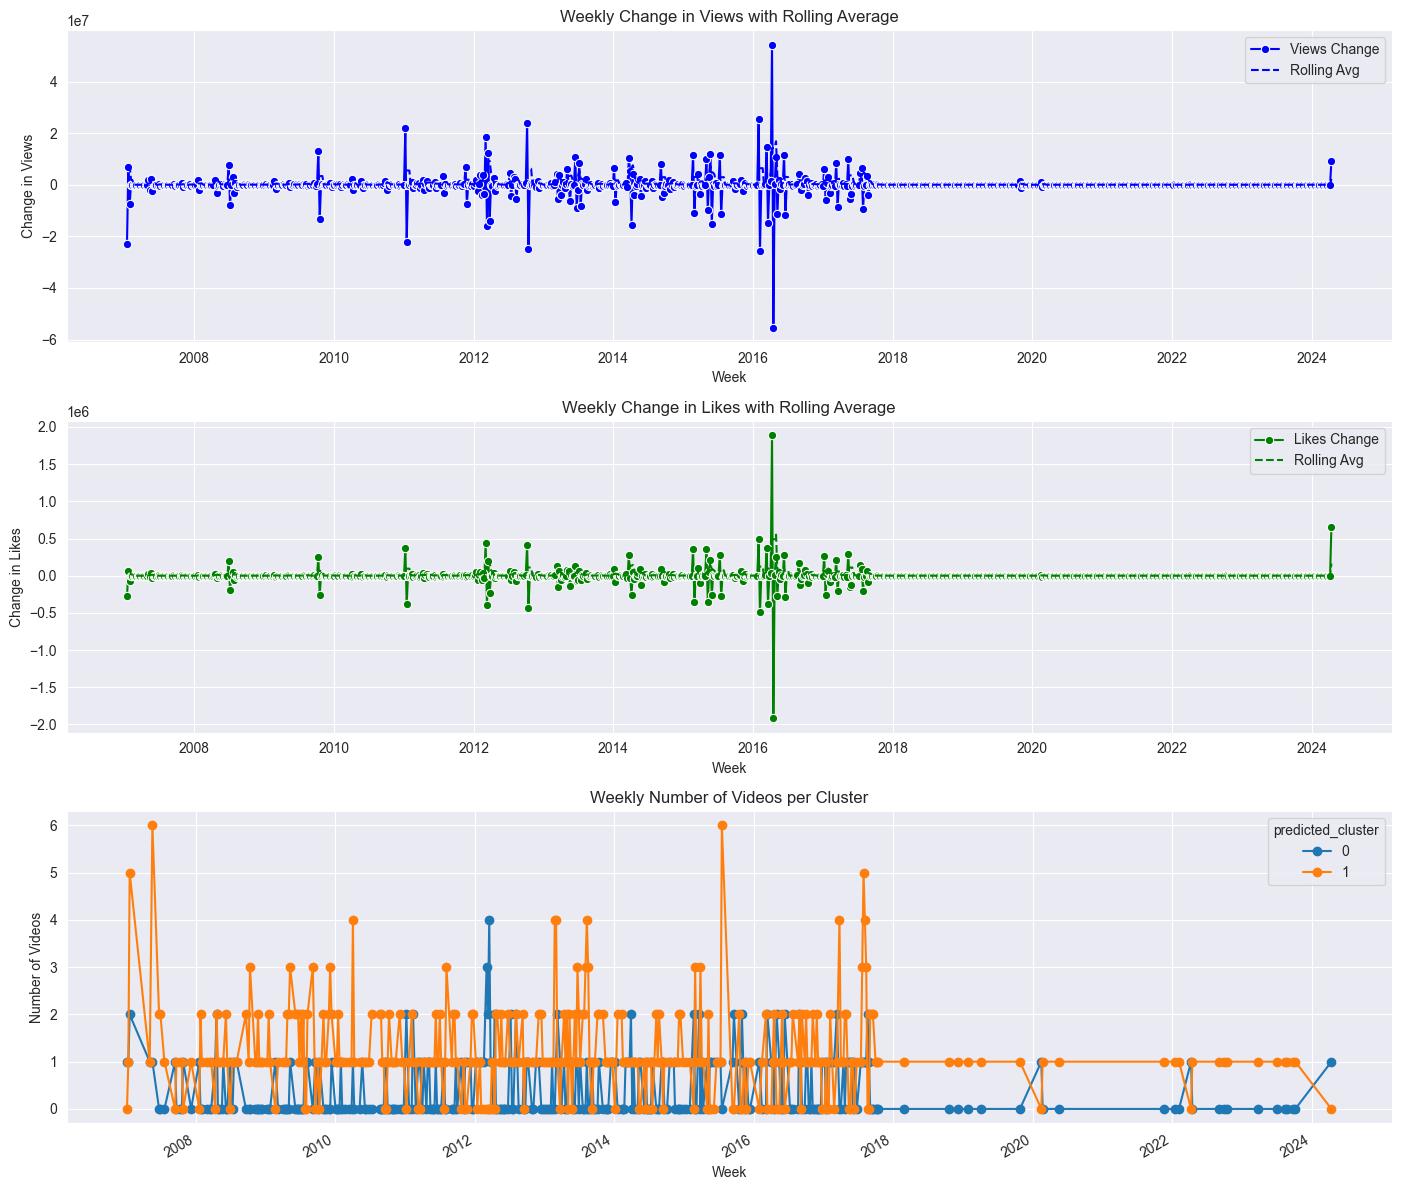

In [192]:
plt.figure(figsize=(14, 12))

# Plot weekly change in views
plt.subplot(3, 1, 1)
sns.lineplot(data=df_weekly, x=df_weekly.index, y='views_change', marker='o', color='b', label='Views Change')
sns.lineplot(data=df_weekly, x=df_weekly.index, y='views_rolling_avg', linestyle='--', color='blue', label='Rolling Avg')
plt.title('Weekly Change in Views with Rolling Average')
plt.xlabel('Week')
plt.ylabel('Change in Views')

# Plot weekly change in likes
plt.subplot(3, 1, 2)
sns.lineplot(data=df_weekly, x=df_weekly.index, y='likes_change', marker='o', color='g', label='Likes Change')
sns.lineplot(data=df_weekly, x=df_weekly.index, y='likes_rolling_avg', linestyle='--', color='green', label='Rolling Avg')
plt.title('Weekly Change in Likes with Rolling Average')
plt.xlabel('Week')
plt.ylabel('Change in Likes')

# Plot the number of videos per cluster over time
plt.subplot(3, 1, 3)
cluster_counts = df.resample('W')['predicted_cluster'].value_counts().unstack().fillna(0)
cluster_counts.plot(ax=plt.gca(), marker='o')
plt.title('Weekly Number of Videos per Cluster')
plt.xlabel('Week')
plt.ylabel('Number of Videos')

plt.tight_layout()
plt.show()

### Descriptive Analysis Summary

In this analysis, we explored a dataset of TED videos, focusing on understanding engagement metrics such as views, likes, and comments. We began by preprocessing the data, ensuring consistency by converting key columns to numerical types and addressing missing values. Next, we engineered additional features, including the length of video titles, video durations, and time-based features like the year and month of publication. To handle the skewed distribution of engagement metrics, we applied log transformations, providing a more balanced view of the data.

We performed a time-based analysis by resampling the data on a weekly basis, allowing us to observe trends in views and likes over time. The introduction of rolling averages smoothed out short-term fluctuations, revealing long-term patterns of audience engagement. Additionally, we employed a clustering model to segment the videos into distinct groups based on their log-transformed engagement metrics. This revealed clusters of videos with similar performance characteristics, offering insights into the types of content that tend to attract more viewers and engagement.

Through visualizations, including histograms, line plots, and cluster trend analysis, we gained a comprehensive understanding of the dataset. Our findings highlighted that a small number of videos dominate viewership, while the majority show moderate engagement. Cluster analysis further emphasized the existence of distinct video groups, from highly viral content to videos with lower but more consistent engagement. This analysis provides a solid foundation for further exploration into content performance and potential strategies to enhance video engagement.
